# Task size based slashing

Task size-based slashing adjusts penalties and rewards according to the size or complexity of the task. This approach ensures that larger or more complex tasks carry proportional stakes, aligning incentives and penalties with the task's importance.  

This approach also ensures that users cannot fail on very big tasks and recover their lost stake on small and cheap tasks.  

## Task Size Metric
Firstly, we need to define a metric for the task size.  

### Practical standpoint

In practice, the task size could be quantified as the total price paid for the task. However the price might be inflated using pumped up app or dataset cost. The most reliable and trustworthy way to quantify the size of a task would be to rely on the computational cost.    

The iExec marketplace already provides a tool to quantify task size through its' proof of contribution (PoC) protocol.

iExec uses a "pay-per-task" model where tasks are categorized based on their complexity and computational requirements. The categories are defined by the maximum computing time (`C`) and maximum deal time (`D`). This categorization helps to standardize task sizes, making it easier to apply our slashing and reward formulas proportionally.

| Category | Maximum Computing Time (C) | Maximum Deal Time (D)   |
|----------|-----------------------------|-------------------------|
| 0 – XS   | 5 min                       | 50 min                  |
| 1 – S    | 20 min                      | 200 min (3h20m)         |
| 2 – M    | 1 hour                      | 10h                     |
| 3 – L    | 3 hours                     | 30h (1d6h)              |
| 4 – XL   | 10 hours                    | 100h (4d4h)             |

Each worker allocates `C` minutes to compute the application. If the computation is not completed within the Maximum Computing Time, the application is stopped. From the buyer's perspective, a requester can claim a task of a deal after `D` minutes if the task is not completed.

By defining task sizes using iExec's categories, we ensure a standardized approach to slashing and rewards. Task size \( T_s \) can be mapped to these categories, making the system both scalable and fair. However there might be an interest to artificially increase a task size so as to recover more money on a successful task. The opposite is not possible, as if you artificially decrease a task size, it may not have enough time allocated to be executed.

### Theoretical standpoint

In our theoretical approach, we'll push aside those concern and consider that we have a fair and reliable way to quantify task size.

The task size could be quantified by computational cost or the total price paid for the task in a reliable and trustworthy manner. For theoretical purposes, we assume the task size $ T_s $ is known, with $ 0 \leq T_s \leq 1 $, where 0 is the smallest possible task and 1 is the largest.

The question of the referential arises, should we base our task size measurement on the global biggest and smallest possible task, or should we base it on the user biggest and smallest task achieved yet. While the latter seem easier to quantify and achieve, it also seem easier to manipulate for a user.  

## Updated slashing formula

To update our model and take into account task size, we could simply reuse the accelerated slashing strategy exponential formula and dedicate one of the parameter to task size.  

In the following function:
$$
y = \alpha^{x+\beta}+\omega
$$

$\alpha$ (Slope of the Curve):  
Effect: Changing alpha affects how rapidly the penalty increases as unreliability increases. A higher alpha means that penalties increase more steeply with increased unreliability.  
Implication for Task Size: Associating alpha with task size means that larger tasks would result in a steeper increase in penalties for failures. This could be useful because larger tasks should ideally have more severe penalties for failures to reflect their higher importance.  

$\beta$ (Horizontal Shift):  
Effect: Adjusting beta shifts the entire curve left or right. This affects the point on the x-axis (unreliability) where penalties start to become significant.  
Implication for Task Size: If beta is adjusted based on task size, it would change the threshold at which penalties become impactful for different tasks. This might not directly reflect the importance of the task but rather how "early" or "late" penalties begin to affect different tasks.  

$\omega$ (Vertical Shift):  
Effect: Modifying omega changes the starting point of the penalty on the y-axis. This affects the minimum penalty imposed.  
Implication for Task Size: If omega is adjusted based on task size, it would set a higher baseline penalty for larger tasks. This would mean that the starting penalty level is higher for larger tasks, but the rate of increase remains constant.

The parameters we choose is subjective to the desired effect. And a valid argument could be made for each parameter:  
$\alpha$ allows us to punish more severily for tasks, whereas $\beta$ allows us to delay higher punishment for smaller tasks and $\omega$ could allow us to set a more constant increment to base penalty based on task size.  
I might want to explore the exponential function more in debt to be able to quantify the impact of changes on the parameter as a regard of net loss per user and time to ruin.

## Python implementation

Let's first start with an implementation of task size unrelated to the exponential formula.  

For now we'll consider that each user is working on a fixed task size so as to be able to visualize the impact of task size on time to ruin.  

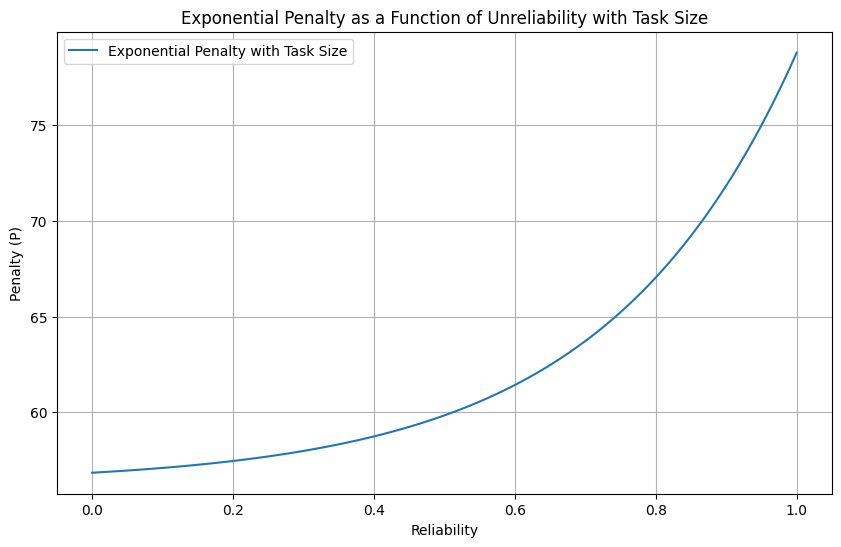

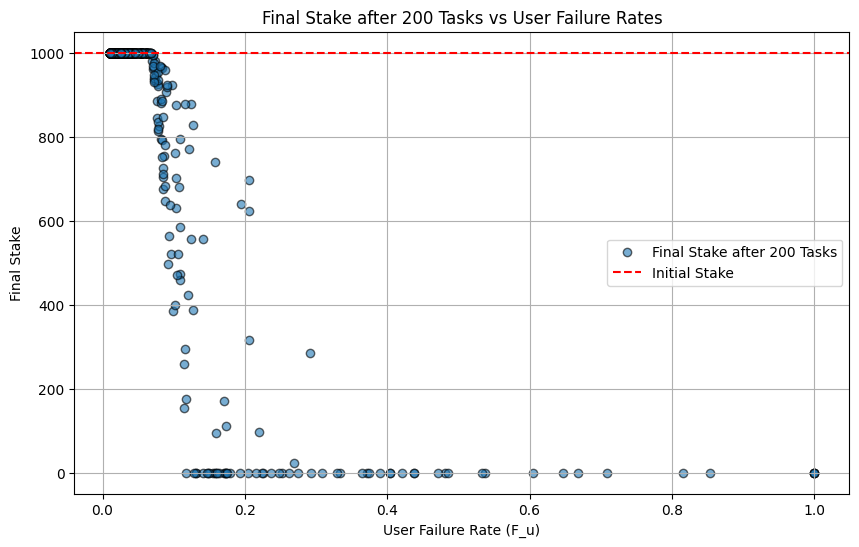

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the overall task failure rate
def calculate_failure_rate(F_u, mean_F_u):
    return 1 - (1 - F_u) * (1 - mean_F_u) ** 3

# Exponential slashing function for penalty P based on remaining stake and task size
def exponential_penalty(reliability, alpha, beta, omega, task_size):
    return (alpha ** (reliability + beta) + omega) * task_size

# Function to calculate the net loss in stake per task
def net_loss_per_task(F, P, F_t):
    return (F * P) / (1 - F_t) - (F_t * P) / (1 - F_t)

# Generate a long-tailed distribution for user failure rates (F_u)
shape, scale = 1.0, 0.01  # shape (alpha) and scale (xmin) parameters for the Pareto distribution
F_u_values = (np.random.pareto(shape, 1000) + 1) * scale

# Ensuring that failure rates are within a realistic range [0, 1]
F_u_values = np.clip(F_u_values, 0, 1)

# Calculate the mean failure rate from the generated distribution
mean_F_u = np.mean(F_u_values)

# Parameters
S_0 = 1000  # initial stake
F_t = 0.2   # desired failure rate
num_tasks = 200  # number of tasks

# Exponential slashing parameters
alpha = 40.0
beta = 0.0
omega = 100.0

# Define task sizes (0 <= T_s <= 1), for example, using a uniform distribution
task_sizes = np.random.uniform(0.1, 1.0, size=F_u_values.shape)

# Calculate overall task failure rate for each user failure rate
F_values = calculate_failure_rate(F_u_values, mean_F_u)

# Initialize stakes as float
stakes = np.full(F_u_values.shape, S_0, dtype=float)

# Simulate the evolution of stakes over the specified number of tasks
for _ in range(num_tasks):
    reliability = (S_0 - stakes) / S_0
    P_values = exponential_penalty(reliability, alpha, beta, omega, task_sizes)
    L_net_values = net_loss_per_task(F_values, P_values, F_t)
    
    stakes += -L_net_values
    stakes = np.maximum(stakes, 0)  # Ensure stakes do not fall below 0
    stakes = np.minimum(stakes, S_0)  # Ensure stakes do not exceed initial stake

# Plot the penalty as an exponential function of reliability, averaged over task sizes
plt.figure(figsize=(10, 6))
reliability_range = np.linspace(0, 1, 100)
average_task_size = np.mean(task_sizes)
penalty_values = exponential_penalty(reliability_range, alpha, beta, omega, average_task_size)
plt.plot(reliability_range, penalty_values, label='Exponential Penalty with Task Size')
plt.xlabel('Reliability')
plt.ylabel('Penalty (P)')
plt.title('Exponential Penalty as a Function of Unreliability with Task Size')
plt.legend()
plt.grid(True)
plt.show()

# Plot the final stakes after the specified number of tasks
plt.figure(figsize=(10, 6))
plt.scatter(F_u_values, stakes, alpha=0.6, edgecolor='black', label='Final Stake after ' + str(num_tasks) + ' Tasks')
plt.axhline(S_0, color='r', linestyle='--', label='Initial Stake')
plt.xlabel('User Failure Rate (F_u)')
plt.ylabel('Final Stake')
plt.title('Final Stake after ' + str(num_tasks) + ' Tasks vs User Failure Rates')
plt.legend()
plt.grid(True)
plt.show()


We observe a spread on our graph that suggests adding the concept of task size to our formula introduces more randomness. In the context of controlling time to ruin, this means users have more control since the size of the tasks they undertake significantly impacts the time it takes for them to get ruined. While small failed tasks become less costly, the overall failure rate might remain above our target for a longer period even if the money at stake is not as important. This is an important factor to consider.  

## Python implementation with exponential formula

Let's try implementing task size based slashing using the exponential formula.

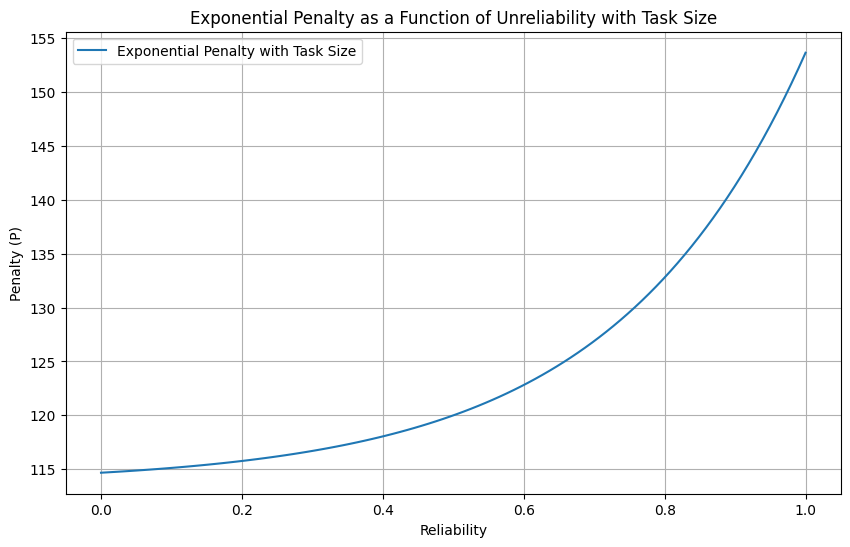

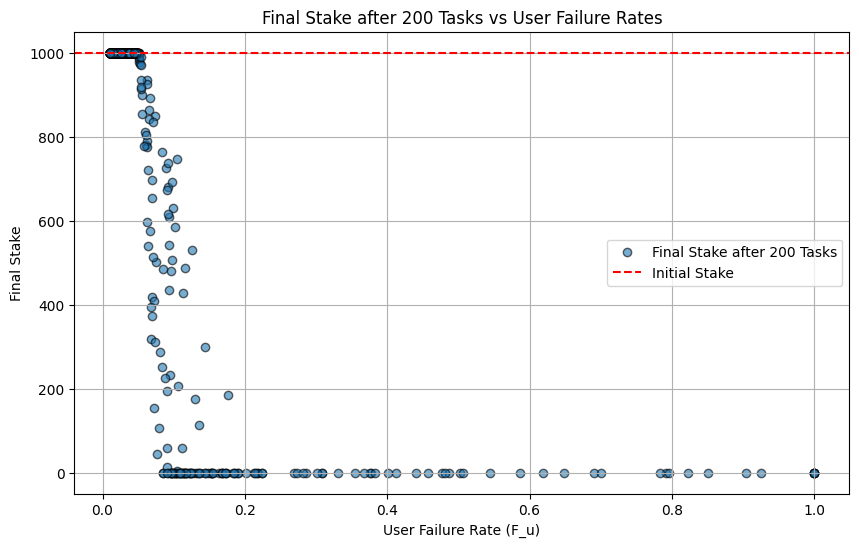

In [9]:
# Function to calculate the overall task failure rate
def calculate_failure_rate(F_u, mean_F_u):
    return 1 - (1 - F_u) * (1 - mean_F_u) ** 3

# Exponential slashing function for penalty P based on remaining stake and task size
def exponential_penalty(reliability, alpha, beta, omega):
    return alpha ** (reliability + beta) + omega

# Function to calculate the net loss in stake per task
def net_loss_per_task(F, P, F_t):
    return (F * P) / (1 - F_t) - (F_t * P) / (1 - F_t)

# Generate a long-tailed distribution for user failure rates (F_u)
shape, scale = 1.0, 0.01  # shape (alpha) and scale (xmin) parameters for the Pareto distribution
F_u_values = (np.random.pareto(shape, 1000) + 1) * scale

# Ensuring that failure rates are within a realistic range [0, 1]
F_u_values = np.clip(F_u_values, 0, 1)

# Calculate the mean failure rate from the generated distribution
mean_F_u = np.mean(F_u_values)

# Parameters
S_0 = 1000  # initial stake
F_t = 0.2   # desired failure rate
num_tasks = 200  # number of tasks

# Exponential slashing parameters
alpha = 40.0
beta = 0.0
omega = 200.0

# Define task sizes (0 <= T_s <= 1), for example, using a uniform distribution
task_sizes = np.random.uniform(0.1, 1.0, size=F_u_values.shape)

# Calculate overall task failure rate for each user failure rate
F_values = calculate_failure_rate(F_u_values, mean_F_u)

# Initialize stakes as float
stakes = np.full(F_u_values.shape, S_0, dtype=float)

# Simulate the evolution of stakes over the specified number of tasks
for _ in range(num_tasks):
    reliability = (S_0 - stakes) / S_0
    P_values = exponential_penalty(reliability, alpha, beta, omega*task_sizes)
    L_net_values = net_loss_per_task(F_values, P_values, F_t)
    
    stakes += -L_net_values
    stakes = np.maximum(stakes, 0)  # Ensure stakes do not fall below 0
    stakes = np.minimum(stakes, S_0)  # Ensure stakes do not exceed initial stake

# Plot the penalty as an exponential function of reliability, averaged over task sizes
plt.figure(figsize=(10, 6))
reliability_range = np.linspace(0, 1, 100)
average_task_size = np.mean(task_sizes)
penalty_values = exponential_penalty(reliability_range, alpha, beta, omega*average_task_size)
plt.plot(reliability_range, penalty_values, label='Exponential Penalty with Task Size')
plt.xlabel('Reliability')
plt.ylabel('Penalty (P)')
plt.title('Exponential Penalty as a Function of Unreliability with Task Size')
plt.legend()
plt.grid(True)
plt.show()

# Plot the final stakes after the specified number of tasks
plt.figure(figsize=(10, 6))
plt.scatter(F_u_values, stakes, alpha=0.6, edgecolor='black', label='Final Stake after ' + str(num_tasks) + ' Tasks')
plt.axhline(S_0, color='r', linestyle='--', label='Initial Stake')
plt.xlabel('User Failure Rate (F_u)')
plt.ylabel('Final Stake')
plt.title('Final Stake after ' + str(num_tasks) + ' Tasks vs User Failure Rates')
plt.legend()
plt.grid(True)
plt.show()
